Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [56]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
path = "../"
category = "balanced_data"
# category = "imbalanced_data"
category = "real_data"

In [58]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")
df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"])

df_k = df[[
    'dataset',
    'dropout',
    'kmeans_ari_0',
    'kmeans_nmi_0',
    'run',
    "time",
    'kmeans_pred_0',
]].rename(columns={
    'kmeans_ari_0': "ARI",
    'kmeans_nmi_0': "NMI",
    'kmeans_pred_0': 'pred'
})
df_k["method"] = "Ours+KM"

df_l = df[[
    'dataset',
    'dropout',
    'leiden_ari_0',
    'leiden_nmi_0',
    'run',
    'time',
    'leiden_pred_0',
]].rename(columns={
    'leiden_ari_0': "ARI",
    'leiden_nmi_0': "NMI",
    'leiden_pred_0': 'pred'
})

df_l["method"] = "Ours+Leiden"

r_data = pd.read_pickle(f"../R/{category}.pkl")

scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
scDeepCluster["method"] = "scDeepCluster"

sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
sczi["method"] = "sczi"

scedar = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scedar.pkl")
scedar["method"] = "scedar"

scanpy = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scanpy.pkl")
scanpy["method"] = "scanpy"

scrna = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scrna.pkl")
scrna["method"] = "scrna"

pca_kmeans = pd.read_pickle(f"../output/pickle_results/{category}/{category}_pca_kmeans.pkl")
pca_kmeans["method"] = "pca_kmeans"

desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_desc.pkl")
desc["pred"] = desc["pred"].apply(lambda x: x.to_list())
desc["method"] = "desc"

all_data = pd.concat([df_k, df_l, r_data, desc,pca_kmeans, sczi, 
                      scDeepCluster ,scedar, scanpy, scrna])
all_data = all_data.reset_index(drop = True)

In [59]:
all_data

,dataset,dropout,ARI,NMI,run,time,pred,method,sil
0,Quake_Smart-seq2_Trachea,0.9,0.502064,0.580774,0,2.611309,"[0, 3, 2, 3, 3, 0, 2, 3, 3, 0, 0, 2, 0, 0, 0, ...",Ours+KM,NaN
1,Quake_Smart-seq2_Trachea,0.9,0.469278,0.542781,1,0.964024,"[0, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, ...",Ours+KM,NaN
2,Quake_Smart-seq2_Diaphragm,0.9,0.985385,0.972357,0,0.697230,"[0, 1, 1, 3, 3, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...",Ours+KM,NaN
3,Quake_Smart-seq2_Diaphragm,0.9,0.983543,0.966968,1,0.721800,"[0, 2, 2, 4, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Ours+KM,NaN
4,Quake_10x_Spleen,0.9,0.493249,0.641360,0,6.730129,"[0, 1, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 4, 0, 0, ...",Ours+KM,NaN
...,...,...,...,...,...,...,...,...,...
553,mouse_bladder_cell_select_2100,NaN,0.447029,0.647230,1,7.032641,"[13, 9, 4, 2, 5, 6, 0, 4, 8, 13, 1, 1, 9, 8, 1...",scrna,-0.067917
554,mouse_bladder_cell_select_2100,NaN,0.447029,0.647230,2,7.035458,"[13, 9, 4, 2, 5, 6, 0, 4, 8, 13, 1, 1, 9, 8, 1...",scrna,-0.067917
555,10X_PBMC,NaN,0.471505,0.529170,0,8.513393,"[1, 3, 3, 2, 2, 2, 0, 4, 7, 7, 7, 2, 2, 2, 2, ...",scrna,0.068982
556,10X_PBMC,NaN,0.471505,0.529170,1,8.726190,"[1, 3, 3, 2, 2, 2, 0, 4, 7, 7, 7, 2, 2, 2, 2, ...",scrna,0.068982


In [60]:
all_data["Silhouette"] = np.nan
all_data["Calinski"] = np.nan

In [61]:
path= ".."
if category in ["balanced_data", "imbalanced_data"]:
    files = glob2.glob(f'{path}/R/simulated_data/{category}/*.h5')
    files = [f[len(f"{path}/R/simulated_data/{category}/"):-3] for f in files]
else:
    files = glob2.glob(f'{path}/real_data/*.h5')
    files = [f[len(f"{path}/real_data/"):-3] for f in files]
print(files)

for dataset in tqdm(files):
    if category in ["balanced_data", "imbalanced_data"]:
        data_mat = h5py.File(f"{path}/R/simulated_data/{category}/{dataset}.h5","r")
    else:
        data_mat = h5py.File(f"{path}/real_data/{dataset}.h5","r")

    Y = np.array(data_mat['Y'])
    X = np.array(data_mat['X'])
    X = train.preprocess(X, nb_genes=500)
    X = PCA(n_components=5).fit_transform(X)
    
    ss = [silhouette_score(X,predi ) for predi in all_data[all_data["dataset"] == dataset]["pred"].values ]
    all_data.loc[all_data[all_data["dataset"] == dataset].index.values, "Silhouette"] = ss
    ss = [davies_bouldin_score(X,predi ) for predi in all_data[all_data["dataset"] == dataset]["pred"].values ]
    all_data.loc[all_data[all_data["dataset"] == dataset].index.values, "Calinski"] = ss
#     ss = [calinski_harabasz_score(X,predi ) for predi in all_data[all_data["dataset"] == dataset]["pred"].values ]
#     all_data.loc[all_data[all_data["dataset"] == dataset].index.values, "Calinski"] = ss


['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']


(1350, 23341) (1350, 23341) keeping 500 genes
(870, 23341) (870, 23341) keeping 500 genes
(9552, 23341) (9552, 23341) keeping 500 genes
(5685, 33658) (5685, 33658) keeping 500 genes
(2717, 24175) (2717, 24175) keeping 500 genes
(3660, 23797) (3660, 23797) keeping 500 genes
(2500, 23341) (2500, 23341) keeping 500 genes
(1676, 23341) (1676, 23341) keeping 500 genes
(3909, 23341) (3909, 23341) keeping 500 genes
(4186, 13488) (4186, 13488) keeping 500 genes
(2746, 20670) (2746, 20670) keeping 500 genes
(2881, 21143) (2881, 21143) keeping 500 genes
(1090, 23341) (1090, 23341) keeping 500 genes
(2122, 19046) (2122, 19046) keeping 500 genes
(4271, 16653) (4271, 16653) keeping 500 genes



In [7]:
if category in ["imbalanced_data", "balanced_data"]:
    sc_dropout = {
        'data_1c8': 0.3,
        'data_-1c4': 0.08,
        'data_-1c8': 0.08,
        'data_0c4': 0.17,
        'data_0c8': 0.17,
        'data_0c16': 0.17,
        'data_1.5c4': 0.38,
        'data_1c4': 0.3,
        'data_1.5c8': 0.38,
        'data_1.5c16': 0.38,
        'data_-1c16': 0.08,
        'data_1c16': 0.3,
        'data_0c32': 0.17,
        'data_1.5c32': 0.38,
        'data_1c32': 0.3,
        'data_-1c32': 0.08
    }
    all_data["dropout"] = all_data["dataset"].apply(lambda x: sc_dropout[x])
    all_data["nb_clust"]= all_data["dataset"].apply(lambda x: int(x.split("c")[1]))

In [62]:
ordered_methods = [
    'Ours+KM',
    'Ours+Leiden',
    'sczi',
    'scDeepCluster',
    'desc',
    'scanpy',
    'scedar',
    'scrna',
    'soup',
    'simlr',
    'raceid',
    'cidr',
    'pca_kmeans',
]
ordered_methods = dict(zip(ordered_methods, np.arange(len(ordered_methods))))

all_data["order"] = all_data["method"].apply(lambda x: ordered_methods[x])

In [9]:
all_data.to_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [ ]:
# category = "imbalanced_data"
# category = "balanced_data"
# category = "real_data"
# all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [10]:
import seaborn as sns

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

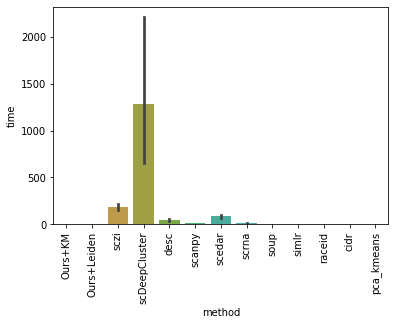

In [11]:
sns.barplot(x = "method", y="time", data = all_data.sort_values(by="order"))
plt.xticks(rotation = 90)

In [12]:
clrs = ['#C0392B', "#F1948A", "#D7BDE2", "#8E44AD", "#7FB3D5", "#2874A6", "#76D7C4", "#117A65",
        "#A9DFBF", "#F1C40F", "#EB984E", "#839192", "#566573"
       ]
len(clrs)

13

# Real Data

In [63]:
all_data = all_data[~all_data["dataset"].str.contains("2100")]

In [64]:
datasets = all_data["dataset"].unique()
datasets

array(['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm',
       'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam',
       'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung',
       'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell',
       'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC'],
      dtype=object)

In [65]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
}

all_data["dataset"] =all_data["dataset"].apply(lambda x: dataset_names.get(x, x))

datasets = [
'QS Trachea', 'QS Diaphragm', 'Q Spleen','Q Bladder', 'QS Lung', 'Q Limb Muscle','QS Limb Muscle',
]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


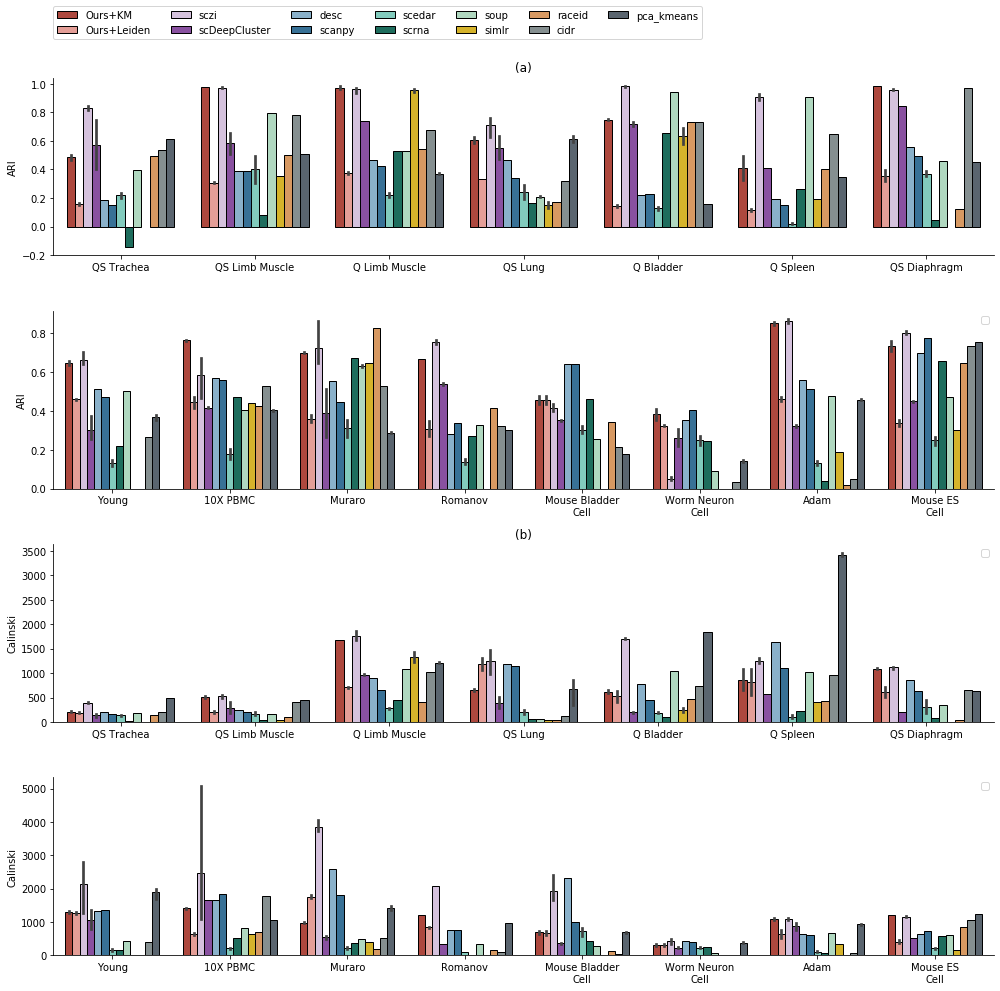

In [55]:
plt.figure(figsize = (14, 14))
ax = plt.subplot(411)
plt.title("(a)")
sns.barplot(x = "dataset", y="ARI", hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.4), loc=2, borderaxespad=0., ncol = 7)
plt.xlabel("")
sns.despine()

ax = plt.subplot(412)
sns.barplot(x = "dataset", y="ARI", hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.xlabel("")


ax = plt.subplot(413)
plt.title("(b)")
sns.barplot(x = "dataset", y='Calinski', hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()

ax = plt.subplot(414)
sns.barplot(x = "dataset", y='Calinski', hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.tight_layout()
plt.xlabel("")
plt.savefig(f"../diagrams/{category}_ARI_barplot.pdf", bbox_inches='tight')

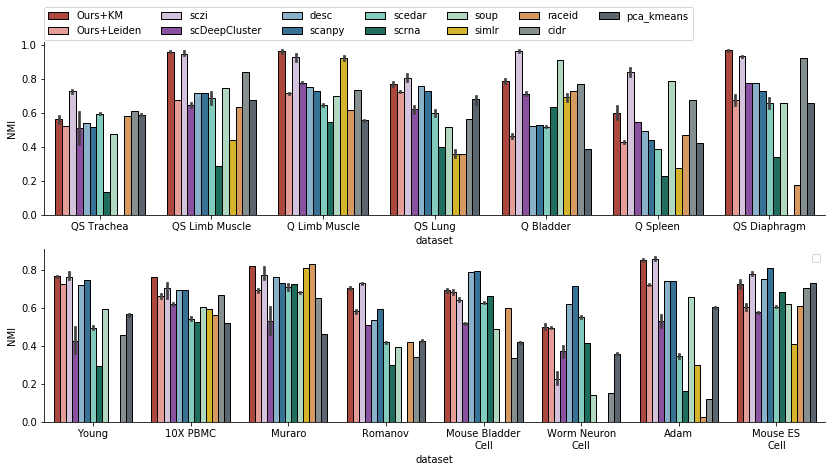

In [49]:
plt.figure(figsize = (14, 7))
ax = plt.subplot(211)
sns.barplot(x = "dataset", y="NMI", hue = "method", 
            data = all_data[all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.2), loc=2, borderaxespad=0., ncol = 7)
sns.despine()

ax = plt.subplot(212)
sns.barplot(x = "dataset", y="NMI", hue = "method", 
            data = all_data[~all_data["dataset"].isin(datasets)].sort_values(by="order"),
            palette=clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
sns.despine()
plt.savefig(f"../diagrams/{category}_NMI_barplot.pdf", bbox_inches='tight')

# Overall Comparaision

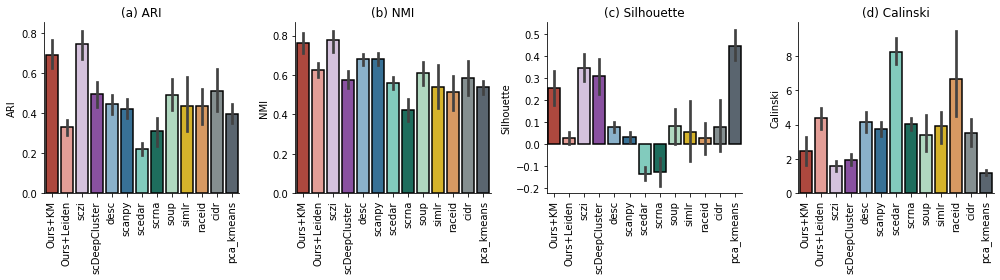

In [66]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(141)
sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(a) ARI")
plt.xlabel("")
sns.despine()

ax = plt.subplot(142)
sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.xlabel("")
plt.title("(b) NMI")

ax = plt.subplot(143)
sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(c) Silhouette")
plt.xlabel("")
sns.despine()

ax = plt.subplot(144)
sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.title("(d) Calinski")
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot.pdf", bbox_inches='tight')

In [ ]:
titles = ["(a)", "(b)", "(c)", "(d)"]
plt.figure(figsize = (12, 5))
for i, dropout in enumerate(sorted(all_data.dropout.unique())):
    ax = plt.subplot(2, 2, i+1)
    sns.barplot(x = "nb_clust", y="ARI", 
                data = all_data[all_data["dropout"] == dropout].sort_values(by=["nb_clust", "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{titles[i]} dropout rate {dropout} %")
    if i ==1:
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    else: 
        plt.legend([],[], frameon=False)
    if i in [2, 3]:
        plt.xlabel("Nb. of clusters")
    else:
        plt.xlabel("")
    sns.despine()
# plt.tight_layout()
plt.savefig(f"../diagrams/{category}_barplot_by_dropout.pdf", bbox_inches='tight')

In [ ]:
plt.figure(figsize=(14, 12))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["balanced data", "imbalanced data", "real data"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):
    all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
    
    ax = plt.subplot(3,4,i*4 +1)
    sns.barplot(x = "method", y="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4]} ARI {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +2)
    sns.barplot(x = "method", y="NMI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.xlabel("")
    plt.title(f"{letters[i*4 +1]} NMI {titles[i]}")

    ax = plt.subplot(3,4,i*4 +3)
    sns.barplot(x = "method", y="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +2]} Silhouette {titles[i]}")
    plt.xlabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +4)
    sns.barplot(x = "method", y="Calinski", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.xticks(rotation = 90)
    plt.title(f"{letters[i*4 +3]}  Calinski {titles[i]}")
    plt.xlabel("")
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_barplot.pdf", bbox_inches='tight')

In [ ]:
df.groupby("dataset").mean()

# Importance of input size

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_genes", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    for run in range(2):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        for nb_genes in [100, 200, 500, 1000, 1500, 2000, 5000, 8000]:

            X = np.array(data_mat['X'])
            Y = np.array(data_mat['Y'])
            perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
            print(f"Perc 0 {perc_0}")
            cluster_number = np.unique(Y).shape[0]

            X = train.preprocess(X, nb_genes=nb_genes)
            nb_zeros = int(0.8 * nb_genes)
            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=100,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/inputs/{dataset}_{nb_genes}/")

            #         df.loc[df.shape[0]] = [
            #                 dataset, perc_0, nb_genes, 'kmeans_representation_0',dresults['kmeans_representation_0']
            #             ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'leiden_representation_0',
                dresults['leiden_representation_0'], run]

#             pxt = PCA(2).fit_transform(X)
#             dresults["original"] = utils.evaluate(X, Y, cluster_number)[1]
#             dresults["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
            print(dresults)
    df.to_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df.groupby(["nb_genes"]).mean()

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_genes": "Nb input genes"})

In [ ]:
df["dataset"].unique()


In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size.pdf", bbox_inches='tight')

In [ ]:
datasets = ['10X PBMC (2100)',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Mouse Bladder\n Cell (2100)']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size_2100.pdf", bbox_inches='tight')

# Importance of the number of epochs

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_epochs", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    nb_genes = 1500
    for epochs in [5, 50, 100, 300]:

        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
        print(f"Perc 0 {perc_0}")
        cluster_number = np.unique(Y).shape[0]

        X = train.preprocess(X, nb_genes=nb_genes)
        nb_zeros = int(0.8 * nb_genes)
        for run in range(2):
            torch.manual_seed(run)
            torch.cuda.manual_seed_all(run)
            np.random.seed(run)
            random.seed(run)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=epochs,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/epochs/{dataset}_{epochs}/")

            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'kmeans_representation_0',
                dresults['kmeans_representation_0'], run
            ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'leiden_representation_0',
                dresults['leiden_representation_0'], run
            ]

            print(dresults)
            df.to_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_epochs": "Nb epochs"})

In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(7, 3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb epochs",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title ="Number of epochs",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_nb_epochs.pdf", bbox_inches='tight')